# Feature Sieve
## Dataset: CelebA

In [8]:
import pandas as pd
import torch
from PIL import Image
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import copy
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from torchsummary import summary
from tqdm import tqdm 

In [2]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
GRAYSCALE = False

In [3]:
# Dataset
DATA_DIR = "./CelebA/img_align_celeba/img_align_celeba/"
CSV_DIR = "./CelebA/list_attr_celeba.csv"
data = pd.read_csv(CSV_DIR)
data.replace(-1, 0, inplace = True)
data.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


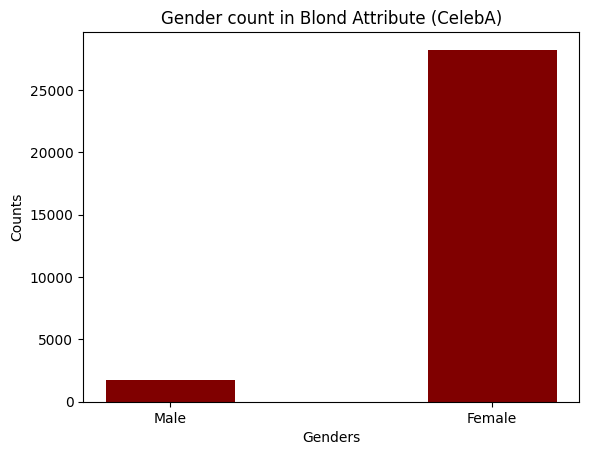

In [20]:
t = data.loc[:, ['Blond_Hair', "Male"]]
blond = t[t['Blond_Hair'] == 1]
male_blond = blond[blond['Male'] == 1]
female_blond = blond[blond['Male'] == 0]

gender = ['Male', "Female"]
counts = [male_blond.shape[0], female_blond.shape[0]]
 
# creating the bar plot
plt.bar(gender, counts, color ='maroon', 
        width = 0.4)
 
plt.xlabel("Genders")
plt.ylabel("Counts")
plt.title("Gender count in Blond Attribute (CelebA)")
plt.show()

In [4]:
# Custom Dataset
custom_transform = transforms.Compose([transforms.Resize((128, 128)),
                                       transforms.RandomCrop((120, 120)),
                                       transforms.ToTensor()])

class CelebADataset(Dataset):
    def __init__(self, dataframe, img_dir, attr = "Blond_Hair", transform = None):
        self.dataframe = dataframe
        self.transform = transform
        self.image_dir = img_dir
        self.images = dataframe["image_id"].values
        self.y = dataframe[attr]

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        img = Image.open(self.image_dir + self.images[index])

        if self.transform is not None:
          img = self.transform(img)
    
        label = self.y[index]
        return img, label

In [5]:
TRAIN_DATAPTS = int(0.6 * len(data))
VAL_DATAPTS = int(0.2 * len(data))
TEST_DATAPTS = int(0.2 * len(data))

print(f"# of Training Datapoints: {TRAIN_DATAPTS}")
print(f"# of Validation Datapoints: {VAL_DATAPTS}")
print(f"# of Test Datapoints: {TEST_DATAPTS}")

data = data.sample(frac = 1).reset_index(drop = True)

train_df = data[:TRAIN_DATAPTS].reset_index(drop = True)
val_df = data[TRAIN_DATAPTS: TRAIN_DATAPTS + VAL_DATAPTS].reset_index(drop = True)
test_df = data[TRAIN_DATAPTS + VAL_DATAPTS: ].reset_index(drop = True)

# of Training Datapoints: 121559
# of Validation Datapoints: 40519
# of Test Datapoints: 40519


In [6]:
# Different groups
male_df = test_df[test_df['Male'] == 1].reset_index(drop = True)
female_df = test_df[test_df['Male'] == 0].reset_index(drop = True)

print(f"Male Datapoints: {male_df.shape[0]}")
print(f"Female Datapoints :{female_df.shape[0]}")

## Hair color and Gender
male_blond_df = male_df[male_df["Blond_Hair"] == 1].reset_index(drop = True)
female_blond_df = female_df[female_df["Blond_Hair"] == 1].reset_index(drop = True)
male_non_blond_df = male_df[male_df['Blond_Hair'] == 0].reset_index(drop = True)
female_non_blond_df = female_df[female_df['Blond_Hair'] == 0].reset_index(drop = True)

print(f"Male Blond: {male_blond_df.shape[0]}")
print(f"FeMale Blond: {female_blond_df.shape[0]}")
print(f"Male Non Blond: {male_non_blond_df.shape[0]}")
print(f"FeMale Non Blond: {female_non_blond_df.shape[0]}")

Male Datapoints: 16925
Female Datapoints :23596
Male Blond: 374
FeMale Blond: 5643
Male Non Blond: 16551
FeMale Non Blond: 17953


In [7]:
# Training Dataset
train_dataset = CelebADataset(dataframe  = train_df,
                             img_dir = DATA_DIR,
                             transform = custom_transform)

train_dataloader = DataLoader(dataset = train_dataset,
                             shuffle = True,
                             batch_size = 128)
# Validation Dataset
val_dataset = CelebADataset(dataframe = val_df,
                           img_dir = DATA_DIR,
                           transform = custom_transform)

val_dataloader = DataLoader(dataset = val_dataset,
                           shuffle = True,
                           batch_size = 128)

# Test Dataset
test_dataset = CelebADataset(dataframe = test_df,
                            img_dir = DATA_DIR,
                            transform = custom_transform)

test_dataloader = DataLoader(dataset = test_dataset,
                            shuffle = True)

In [8]:
# ResNet 34 model for Age Prediction
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

## Resnet Block
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride = stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes, stride = 1)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

## ResNet
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.num_classes = num_classes
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(2048 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = F.softmax(self.fc(x), dim  = 1)
        return logits

## ResNet 34 model
def resnet34(num_classes):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock,
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes,
                   grayscale=GRAYSCALE)
    return model

In [9]:
# Training function
def train_cnn(model, train_dataloader, val_dataloader, epochs = 10, lr =1e-3, wd= 1e-5, verbose = True):
    optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = wd)

    if verbose:
        print("Training Model...............")
    
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in tqdm(range(epochs)):
        tloss = 0
        tloss_num = 0
        correct = 0
        total = 0
        
        model.train()
        for batch_idx, data in enumerate(train_dataloader):
            x, y = data
            x = x.to(torch.float32).to(device)
            y = y.to(torch.long).to(device)

            optimizer.zero_grad()
            out = model(x)
            loss = F.cross_entropy(out, y)
            loss.backward()
            optimizer.step()

            tloss += loss.detach().cpu()
            tloss_num += 1

            _, preds = torch.max(out.data, 1)
            correct += (preds == y).sum().item()
            total += y.shape[0]

        with torch.no_grad():
            vloss = 0
            vloss_num = 0
            vcorrect = 0
            vtotal = 0

            for batch_idx, data in enumerate(val_dataloader):
                x, y = data
                x = x.to(torch.float32).to(device)
                y = y.to(torch.long).to(device)

                out = model(x)
                loss = F.cross_entropy(out, y)

                vloss += loss.detach().cpu()
                vloss_num +=1

                _, preds = torch.max(out.data, 1)
                vcorrect += (preds == y).sum().item()
                vtotal += y.shape[0]

        train_losses.append(float(tloss / tloss_num))
        train_accs.append(float(correct/total))
        val_losses.append(float(vloss / vloss_num))
        val_accs.append(float(vcorrect / vtotal))

        if verbose:
            print(f"Epoch :{epoch}/{epochs}")
            print(f"Training Loss: {tloss / tloss_num} Accuracy: {correct / total}")
            print(f"Validation Loss: {vloss / vloss_num} Accuracy: {vcorrect / vtotal}")

    return model, train_losses, train_accs, val_losses, val_accs

def eval_cnn(model, test_dataloader):
    model.eval()
    tloss = 0
    tloss_num = 0
    total = 0
    correct = 0

    for batch_idx, data in enumerate(test_dataloader):
        x, y = data
        x = x.to(torch.float32).to(device)
        y = y.to(torch.long).to(device)

        out = model(x)
        loss = F.cross_entropy(out, y)

        tloss += loss.detach().cpu()
        tloss_num += 1

        _, preds = torch.max(out.data, 1)
        total += y.shape[0]
        correct += (preds == y).sum().item()

    print(f"Test Loss: {tloss / tloss_num} Accuracy:{correct / total}")
    return tloss / tloss_num, correct / total

In [10]:
def plot_loss_curves(train_loss, val_loss, test_loss, model_name, metric = "loss", epochs = 100):
    plt.plot(range(epochs), train_loss, color = "blue", label = f"Training {metric}")
    plt.plot(range(epochs), val_loss, color = "red", label = f"Validation {metric}")
    plt.plot(range(epochs), [test_loss] * epochs, color = "green", label = f"Test {metric}")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title(model_name)
    plt.legend()
    plt.show()

In [11]:
model = resnet34(2).to(device)
summary(model,(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [34]:
model = resnet34(2).to(device)
model, train_losses, train_accs, val_losses, val_accs = train_cnn(model, train_dataloader, val_dataloader, epochs = 10, verbose = False)
test_loss, test_acc = eval_cnn(model, test_dataloader)

  0%|                                                                                                                                                  | 0/10 [00:34<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
plot_loss_curves(train_losses, val_losses, test_loss, model_name = "CNN Loss Curves", metric = "loss", epochs = 10)
plot_loss_curves(train_accs, val_accs, test_acc, model_name = "CNN Accuracy Currves", metric = "Accuracy", epochs = 10)

## Hyperparameter tuning

In [12]:
lrs = [1e-5, 1e-4, 1e-3]
wds = [1e-5, 1e-4, 1e-3]

test_accs = np.zeros((len(lrs), len(wds)))

for lr in range(len(lrs)):
    for wd in range(len(wds)):
        model = resnet34(2).to(device)
        model, train_losses, train_accs, val_losses, val_accs = train_cnn(model, train_dataloader, val_dataloader, epochs = 1, lr= lrs[lr], wd = wds[wd], verbose = False)
        test_loss, test_acc = eval_cnn(model, test_dataloader)

        test_accs[lr, wd] = test_acc

best_lr, best_wd = np.unravel_index(np.argmax(test_accs), test_accs.shape)
print(f"Best LR: {lrs[best_lr]}")
print(f"Best Weight decay: {wds[best_wd]}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:32<00:00, 332.62s/it]


Test Loss: 0.3759952783584595 Accuracy:0.9351694183263


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:29<00:00, 329.23s/it]


Test Loss: 0.37796929478645325 Accuracy:0.9330470620172256


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:33<00:00, 333.73s/it]


Test Loss: 0.37806519865989685 Accuracy:0.9342316329804299


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:31<00:00, 331.13s/it]


Test Loss: 0.36727070808410645 Accuracy:0.9431899508896622


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:30<00:00, 330.30s/it]


Test Loss: 0.36684155464172363 Accuracy:0.9440783791120654


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:31<00:00, 331.19s/it]


Test Loss: 0.3710487484931946 Accuracy:0.9384023099133783


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:30<00:00, 330.76s/it]


Test Loss: 0.3900444507598877 Accuracy:0.9197206386811777


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:30<00:00, 330.99s/it]


Test Loss: 0.37999433279037476 Accuracy:0.9308506700229511


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:33<00:00, 333.23s/it]


Test Loss: 0.39930400252342224 Accuracy:0.910095999605143
Best LR: 0.0001
Best Weight decay: 0.0001


In [13]:
lrs = [1e-5, 1e-4, 1e-3]
wds = [1e-5, 1e-4, 1e-3]

best_lr = 1
best_wd = 1
# best_lr, best_wd = np.unravel_index(np.argmax(test_accs), test_accs.shape)
print(f"Best LR: {best_lr}")
print(f"Best Weight decay: {best_wd}")


Best LR: 1
Best Weight decay: 1


### Finetuned Model

In [14]:
model = resnet34(2).to(device)
model, train_losses, train_accs, val_losses, val_accs = train_cnn(model, train_dataloader, val_dataloader, epochs = 10, lr = lrs[best_lr], wd = wds[best_wd], verbose = False)
test_loss, test_acc = eval_cnn(model, test_dataloader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [54:57<00:00, 329.78s/it]


Test Loss: 0.36093124747276306 Accuracy:0.9504454480392883


## Group wise Accuracy

In [12]:
#male blond dataloader
male_blond_dataset = CelebADataset(dataframe = male_blond_df,
                            img_dir = DATA_DIR,
                            transform = custom_transform)
male_blond_dataloader = DataLoader(dataset = male_blond_dataset,
                                  shuffle = True,
                                  batch_size= 128)

#female blond dataset
female_blond_dataset = CelebADataset(dataframe = female_blond_df,
                                    img_dir = DATA_DIR,
                                    transform = custom_transform)
female_blond_dataloader = DataLoader(dataset = female_blond_dataset,
                                    shuffle = True,
                                    batch_size = 128)

#male non blond dataset
male_non_blond_dataset = CelebADataset(dataframe = male_non_blond_df,
                                      img_dir = DATA_DIR,
                                      transform = custom_transform)
male_non_blond_dataloader = DataLoader(dataset = male_non_blond_dataset,
                                      shuffle = True,
                                      batch_size = 128)

#female non blond dataloader
female_non_blond_dataset = CelebADataset(dataframe = female_non_blond_df,
                                        img_dir = DATA_DIR,
                                        transform = custom_transform)

female_non_blond_dataloader = DataLoader(dataset = female_non_blond_dataset,
                                        shuffle = True,
                                        batch_size = 128)

In [13]:
# metric: mean group accuracy:
groups = [male_blond_dataloader, female_blond_dataloader, male_non_blond_dataloader, female_non_blond_dataloader]

def mean_group(model, groups, type = "cnn"):
    group_wise_acc_fs = []
    group_wise_loss_fs = []
    groups = [male_blond_dataloader, female_blond_dataloader, male_non_blond_dataloader, female_non_blond_dataloader]
    
    for group in range(len(groups)):
        if type == "cnn":
            loss, acc = eval_cnn(model, groups[group])
        else:
            loss, acc = eval_fsmodel(model, groups[group])
            
        group_wise_acc_fs.append(acc)
        group_wise_loss_fs.append(loss)
    
    mean_group_acc = np.mean(group_wise_acc_fs)
    mean_group_loss = np.mean(group_wise_loss_fs)
    
    print(f"Mean group accuracy: {mean_group_acc}")
    print(f"Mean group loss: {mean_group_loss}")
    return mean_group_acc, mean_group_loss

In [16]:
group_wise_acc = []
group_wise_loss = []
groups = [male_blond_dataloader, female_blond_dataloader, male_non_blond_dataloader, female_non_blond_dataloader]

for group in range(len(groups)):
    loss, acc = eval_cnn(model, groups[group])
    group_wise_acc.append(acc)
    group_wise_loss.append(loss)

mean_cnn_group_acc = np.mean(group_wise_acc)
mean_cnn_group_loss= np.mean(group_wise_loss)
print(f"Mean group wise accuracy: {mean_cnn_group_acc}")
print(f"Mean group wise Loss: {mean_cnn_group_loss}")

Test Loss: 0.863316535949707 Accuracy:0.4326647564469914
Test Loss: 0.48938846588134766 Accuracy:0.8174760787145694
Test Loss: 0.323468953371048 Accuracy:0.9887747790780989
Test Loss: 0.346209317445755 Accuracy:0.9647190383002516
Mean group wise accuracy: 0.8009086631349778
Mean group wise Loss: 0.5055958032608032


## Feature Sieve Model

In [14]:
class Feature_Sieve(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.num_classes = num_classes
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(Feature_Sieve, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(2048 * block.expansion, self.num_classes)

        self.inplanes = 64
        self.auxlayer1 = self._make_layer(block, 64, layers[0], stride = 2)
        self.auxlayer2 = self._make_layer(block,  64, layers[1], stride=2)
        # self.auxlayer3 = self._make_layer(block, 128, layers[2], stride = 2)
        self.aux_avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.aux_fc = nn.Linear(4096, self.num_classes)
        # self.aux_out = nn.Linear(128, 1)
        

        self.params = nn.ModuleDict({
            "main": nn.ModuleList([self.conv1, self.bn1, self.relu, self.maxpool, self.layer1, self.layer2, self.layer3, self.layer4, self.avgpool, self.fc]),
            "aux": nn.ModuleList([ self.auxlayer1, self.auxlayer2, self.aux_avgpool, self.aux_fc]),
            "forget": nn.ModuleList([self.conv1, self.bn1, self.relu, self.maxpool, self.layer1])
        })

    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        

        #forward of the main network
        sh = self.layer1(x)
        x = self.layer2(sh)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        #forward of aux network
        aux = self.auxlayer1(sh)
        aux = self.auxlayer2(aux)
        # aux = self.auxlayer3(aux)
        # aux = self.aux_avgpool(aux)
        aux = aux.view(aux.size(0), -1)
        aux = self.aux_fc(aux)
        # aux = self.aux_out(aux)
        
        
        return logits, aux

def feature_sieve(num_classes, grayscale):
    """Constructs a ResNet-34 model."""
    model = Feature_Sieve(block=BasicBlock,
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes,
                   grayscale=grayscale)
    return model

In [15]:
def learn_main(FS, optim_main, x, y):
    FS.train()
    optim_main.zero_grad()
    out = FS(x)[0]
    loss = F.cross_entropy(out, y)
    loss.backward()
    optim_main.step()
    optim_main.zero_grad()
    FS.eval()

def learn_aux(FS, optim_main, optim_aux, x, y, alpha_aux=1):
    FS.train()
    optim_main.zero_grad()
    aux = FS(x)[1]
    loss = alpha_aux * F.cross_entropy(aux, y)
    loss.backward()
    optim_aux.step()
    optim_aux.zero_grad()
    FS.eval()

def forget_aux(FS, optim_forget, x, num_bins):
    FS.train()
    optim_forget.zero_grad()
    aux = FS(x)[1]
    loss = F.cross_entropy(aux, torch.ones_like(aux) * 1/num_bins)
    loss.backward()
    optim_forget.step()
    optim_forget.zero_grad()
    FS.eval()

In [16]:
def train_fs(model, train_dataloader, val_dataloader, forget_iters = 5, aux_iters =1, main_iters =1, lrs = [0.0005, 0.0005, 0.0005],epochs = 100, verbose = False, patience = 3, min_delta = 0.1):
    if verbose:
        print("Training Model..............")

    optim_main = optim.Adam(model.params.main.parameters())
    optim_aux = optim.Adam(model.params.aux.parameters())
    optim_forget = optim.Adam(model.params.forget.parameters())

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    steps = 0
    for epoch in tqdm(range(epochs)):
        tloss = 0
        tloss_num = 0
        tcorrect = 0
        ttotal = 0

        for batch_idx, data in enumerate(train_dataloader):
            x, y = data
            x = x.to(torch.float32).to(device)
            y = y.to(torch.long).to(device)
        
            if main_iters and steps % main_iters == 0:
                learn_main(model, optim_main, x, y)
            if aux_iters and steps % aux_iters == 0:
                learn_aux(model, optim_main, optim_aux, x, y)
            if forget_iters and steps % forget_iters == 0:
                forget_aux(model, optim_forget, x, model.num_classes)

            with torch.no_grad():
                out = model(x)[0]
                loss = F.cross_entropy(out, y)
                tloss += loss.detach().cpu()
                tloss_num += 1

                _, preds = torch.max(out.data, 1)
                tcorrect += (preds == y).sum().item()
                ttotal += y.shape[0]
                steps += 1

        with torch.no_grad():
            vloss = 0
            vloss_num = 0
            vtotal = 0
            vcorrect = 0

            for batch_idx, data in enumerate(val_dataloader):
                x, y = data
                x = x.to(torch.float32).to(device)
                y = y.to(torch.long).to(device)

                out = model(x)[0]
                loss = F.cross_entropy(out, y)
                vloss += loss.detach().cpu()
                vloss_num += 1

                _, preds = torch.max(out.data, 1)
                vtotal += y.shape[0]
                vcorrect += (preds == y).sum().item()

        train_losses.append(tloss / tloss_num)
        train_accs.append(tcorrect / ttotal)
        val_losses.append(vloss / vloss_num)
        val_accs.append(vcorrect /  vtotal)

        if verbose:
            print(f"Epoch: {epoch} / {epochs}")
            print(f"Training Loss: {tloss / tloss_num} Accuracy: {tcorrect / ttotal}")
            print(f"Validation Loss: {vloss / vloss_num} Accuracy: {vcorrect / vtotal}")

    return model, train_losses, train_accs, val_losses, val_accs

def eval_fsmodel(model, test_dataloader):
    tloss = 0
    tloss_num = 0
    total = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, data in enumerate(test_dataloader):
            x, y = data
            x = x.to(torch.float32).to(device)
            y= y.to(torch.long).to(device)

            out = model(x)[0]
            loss = F.cross_entropy(out, y)
            tloss += loss.detach().cpu()
            tloss_num += 1

            _, preds = torch.max(out.data, 1)
            correct += (preds == y).sum().item()
            total += y.shape[0]

    test_loss = tloss / tloss_num
    test_acc = correct / total

    print(f"Test Loss: {test_loss} Test Accuracy :{test_acc}")
    return test_loss, test_acc

In [17]:
model = feature_sieve(2, False).to(device)
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
            Conv2d-2           [-1, 64, 64, 64]           9,408
            Conv2d-3           [-1, 64, 64, 64]           9,408
       BatchNorm2d-4           [-1, 64, 64, 64]             128
       BatchNorm2d-5           [-1, 64, 64, 64]             128
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
              ReLU-8           [-1, 64, 64, 64]               0
              ReLU-9           [-1, 64, 64, 64]               0
        MaxPool2d-10           [-1, 64, 32, 32]               0
        MaxPool2d-11           [-1, 64, 32, 32]               0
        MaxPool2d-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
           Conv2d-14           [-1, 64,

In [ ]:
model = feature_sieve(2, False).to(device)
model, fs_train_losses, fs_train_accs, fs_val_losses, fs_val_accs = train_fs(model, train_dataloader, val_dataloader, epochs = 10, verbose = False)
fs_test_loss, fs_test_acc = eval_fsmodel(model, test_dataloader)

 70%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 7/10 [1:02:09<26:35, 531.98s/it]

In [ ]:
plot_loss_curves(fs_train_losses, fs_val_losses, fs_test_loss, epochs = 10, model_name = "Feature Sieve Loss Curves")
plot_loss_curves(fs_train_accs, fs_val_accs, fs_test_acc, epochs = 10, model_name = "Feature Sieve Accuracy")

### Hyperparameter Tuning

In [45]:
# hyperparameter tuning based on architecture

## different aux layer connections
### 1) To first block: 0.9394634880679154
### 2) To second block: 0.9151551047604946

## different capacity of Aux layer
### 1) 64, 64 : 0.9384
### 2) 128, 128: 0.939
### 3) 64, 128: 0.9430418795192617
### 4) 128, 256: :0.9390192739567138
### 5) 64, 128, 128: 0.9351694183263
### 6) 64, 64, 128: 
### 7) 64, 2 fcs: 0.92
### 8) 64, 64, 64: 
model = feature_sieve(2, False).to(device)
model, fs_train_losses, fs_train_accs, fs_val_losses, fs_val_accs = train_fs(model, train_dataloader, val_dataloader, epochs = 1, verbose = False)
fs_test_loss, fs_test_acc = eval_fsmodel(model, test_dataloader)
mean_group(model, groups, type='fs')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [09:20<00:00, 560.22s/it]


Test Loss: 0.14336559176445007 Test Accuracy :0.9413637373213889
Test Loss: 1.1971088647842407 Test Accuracy :0.4601063829787234
Test Loss: 0.4164236783981323 Test Accuracy :0.8227714033539276
Test Loss: 0.043938905000686646 Test Accuracy :0.9885050517272672
Test Loss: 0.1259642243385315 Test Accuracy :0.9461868419586652
Mean group accuracy: 0.804392420004646
Mean group loss: 0.445858895778656


(0.804392420004646, 0.4458589)

In [17]:
forget_iters = [2, 50, 100]
forget_lrs = [1e-5, 1e-4, 1e-3]
groups = [male_blond_dataloader, female_blond_dataloader, male_non_blond_dataloader, female_non_blond_dataloader]

test_accs = np.zeros((len(forget_lrs), len(forget_iters)))

for i in range(len(forget_lrs)):
    for j in range(len(forget_iters)):
        
            model = feature_sieve(2, False).to(device)
            model, fs_train_losses, fs_train_accs, fs_val_losses, fs_val_accs = train_fs(model, train_dataloader, val_dataloader, epochs = 1, lrs = [1e-4, 1e-4, forget_lrs[i]], forget_iters = forget_iters[j], verbose= False)
            fs_test_loss, fs_test_accs = eval_fsmodel(model, test_dataloader)
    
            test_accs[i,j] = mean_group(model, groups)[0]

best_forget_lr, best_forget_iter = np.unravel_index(np.argmax(test_accs), test_accs.shape)
print(f"Best forget lr: {forget_lrs[best_forget_lr]}")
print(f"Best forget iter: {forget_iters[best_forget_iter]}")


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [11:07<00:00, 667.81s/it]


Test Loss: 0.1698313057422638 Test Accuracy :0.9339601688013622
Test Loss: 1.1746660470962524 Test Accuracy :0.35097493036211697
Test Loss: 0.5441424250602722 Test Accuracy :0.7480861669930567
Test Loss: 0.0791403204202652 Test Accuracy :0.9811571445826791
Test Loss: 0.11581231653690338 Test Accuracy :0.9594707288597321
Mean group accuracy: 0.7599222426993962
Mean group loss: 0.4784402549266815


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [09:52<00:00, 592.18s/it]


Test Loss: 0.1575603187084198 Test Accuracy :0.9368969176476395
Test Loss: 1.764522910118103 Test Accuracy :0.20055710306406685
Test Loss: 0.716614842414856 Test Accuracy :0.6868435107708741
Test Loss: 0.03241842985153198 Test Accuracy :0.9948665297741273
Test Loss: 0.06531023234128952 Test Accuracy :0.9755378884750098
Mean group accuracy: 0.7144512580210195
Mean group loss: 0.6447166204452515


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [09:48<00:00, 588.10s/it]


Test Loss: 0.15700103342533112 Test Accuracy :0.9340095259248291
Test Loss: 1.5517865419387817 Test Accuracy :0.3370473537604457
Test Loss: 0.4533149003982544 Test Accuracy :0.8102189781021898
Test Loss: 0.040253229439258575 Test Accuracy :0.9897934533156179
Test Loss: 0.14442665874958038 Test Accuracy :0.9336743203424696
Mean group accuracy: 0.7676835263801807
Mean group loss: 0.5474452972412109


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [11:01<00:00, 661.78s/it]


Test Loss: 0.19825208187103271 Test Accuracy :0.9087140001480714
Test Loss: 2.0077927112579346 Test Accuracy :0.1309192200557103
Test Loss: 1.1267412900924683 Test Accuracy :0.4299448103970091
Test Loss: 0.018203552812337875 Test Accuracy :0.9983089745138302
Test Loss: 0.03885316103696823 Test Accuracy :0.9922721965864235
Mean group accuracy: 0.6378613003882433
Mean group loss: 0.7978976368904114


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [09:45<00:00, 585.82s/it]


Test Loss: 0.13213969767093658 Test Accuracy :0.9465462352854076
Test Loss: 1.5301004648208618 Test Accuracy :0.37604456824512533
Test Loss: 0.48555824160575867 Test Accuracy :0.797578778707495
Test Loss: 0.031048543751239777 Test Accuracy :0.9910617224302452
Test Loss: 0.08672534674406052 Test Accuracy :0.9637515983766053
Mean group accuracy: 0.7821091669398678
Mean group loss: 0.533358097076416


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [09:37<00:00, 577.61s/it]


Test Loss: 0.163121297955513 Test Accuracy :0.9276671355593396
Test Loss: 1.5047574043273926 Test Accuracy :0.22562674094707522
Test Loss: 0.7481865286827087 Test Accuracy :0.6056613850810041
Test Loss: 0.03201163187623024 Test Accuracy :0.9966783427950235
Test Loss: 0.07459206134080887 Test Accuracy :0.9774281425473953
Mean group accuracy: 0.7013486528426246
Mean group loss: 0.5898869633674622


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [10:46<00:00, 646.00s/it]


Test Loss: 0.16511249542236328 Test Accuracy :0.9312455270106859
Test Loss: 1.3234869241714478 Test Accuracy :0.41225626740947074
Test Loss: 0.44504740834236145 Test Accuracy :0.8260637350899056
Test Loss: 0.08427189290523529 Test Accuracy :0.9670250030196884
Test Loss: 0.1277719885110855 Test Accuracy :0.9426808250403069
Mean group accuracy: 0.7870064576398429
Mean group loss: 0.4951445460319519


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [09:42<00:00, 582.30s/it]


Test Loss: 0.1350981891155243 Test Accuracy :0.9454357000074036
Test Loss: 1.2267168760299683 Test Accuracy :0.467966573816156
Test Loss: 0.46199342608451843 Test Accuracy :0.8118212568987003
Test Loss: 0.042480140924453735 Test Accuracy :0.9878004589926319
Test Loss: 0.0962134301662445 Test Accuracy :0.9605270473119475
Mean group accuracy: 0.8070288342548589
Mean group loss: 0.45685097575187683


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [08:50<00:00, 530.40s/it]


Test Loss: 0.15875907242298126 Test Accuracy :0.9358357394931024
Test Loss: 2.282233476638794 Test Accuracy :0.1671309192200557
Test Loss: 0.7636476755142212 Test Accuracy :0.6644116076197258
Test Loss: 0.012468041852116585 Test Accuracy :0.9978258243749245
Test Loss: 0.060823630541563034 Test Accuracy :0.9778173125034747
Mean group accuracy: 0.7017964159295452
Mean group loss: 0.7797932624816895
Best forget lr: 0.001
Best forget iter: 50


In [18]:
forget_iters = [20, 50, 100]
forget_lrs = [1e-5, 1e-3, 1e-2]
lrs = [1e-5, 1e-4, 1e-3]

best_lr = 1
best_forget_lr = 0
best_forget_iter = 2

### Finetuned model

In [19]:
model = feature_sieve(2, False).to(device)
model, fs_train_lossses, fs_train_accs, fs_val_losses, fs_val_accs = train_fs(model, train_dataloader, val_dataloader, epochs = 10, lrs = [lrs[best_lr], lrs[best_lr], forget_lrs[best_forget_lr]], forget_iters = forget_iters[best_forget_iter], verbose = False)
fs_test_loss, fs_test_acc = eval_fsmodel(model, test_dataloader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [1:20:59<00:00, 485.97s/it]


Test Loss: 0.11016113311052322 Test Accuracy :0.9565163742257101


In [20]:
# 75 1e-5: 81.308
group_wise_acc_fs = []
group_wise_loss_fs = []
groups = [male_blond_dataloader, female_blond_dataloader, male_non_blond_dataloader, female_non_blond_dataloader]

for group in range(len(groups)):
    loss, acc = eval_fsmodel(model, groups[group])
    group_wise_acc_fs.append(acc)
    group_wise_loss_fs.append(loss)

mean_group_acc = np.mean(group_wise_acc_fs)
mean_group_loss = np.mean(group_wise_loss_fs)

print(f"Mean group accuracy: {mean_group_acc}")
print(f"Mean group loss: {mean_group_loss}")

Test Loss: 1.3099322319030762 Test Accuracy :0.4456824512534819
Test Loss: 0.331999808549881 Test Accuracy :0.881075307103436
Test Loss: 0.02497711032629013 Test Accuracy :0.9922695977775093
Test Loss: 0.09595800936222076 Test Accuracy :0.9561349863790516
Mean group accuracy: 0.8187905856283697
Mean group loss: 0.44071677327156067


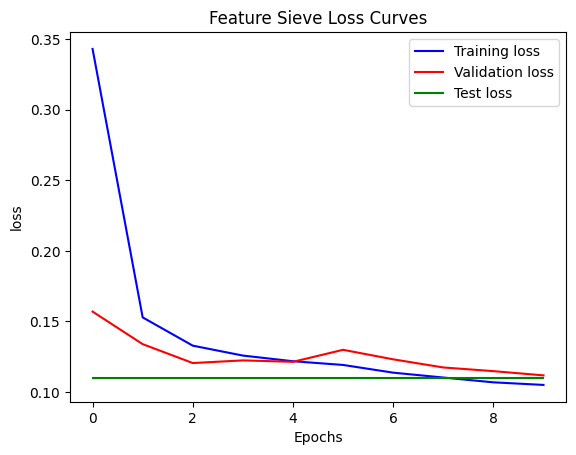

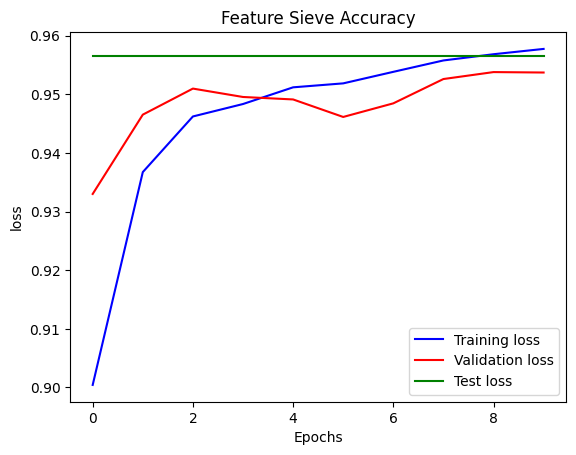

In [21]:
plot_loss_curves(fs_train_lossses, fs_val_losses, fs_test_loss, epochs = 10, model_name = "Feature Sieve Loss Curves")
plot_loss_curves(fs_train_accs, fs_val_accs, fs_test_acc, epochs = 10, model_name = "Feature Sieve Accuracy")

## Comparison plots

In [ ]:
# Plotting the Comparisons
plt.rcParams["figure.figsize"] = (20, 10)
fig, ax = plt.subplots(2, 3)
fig.suptitle("CNN vs Feature Sieve (Space Invaders)")

# Training Loss
ax[0,0].plot(range(len(train_losses)), train_losses, color = "blue", label = "CNN")
ax[0,0].plot(range(len(fs_train_lossses)), fs_train_lossses,color = "red", label= "Feature Sieve")
ax[0,0].set_xlabel("Epochs")
ax[0,0].set_ylabel("Loss")
ax[0,0].set_title("Training Loss")
ax[0,0].legend()

#Validation Loss
ax[0,1].plot(range(len(val_losses)), val_losses, color = "blue", label = "CNN")
ax[0,1].plot(range(len(fs_val_losses)), fs_val_losses, color = "red", label= "Feature Sieve")
ax[0,1].set_xlabel("Epochs")
ax[0,1].set_ylabel("Loss")
ax[0,1].set_title("Validation Loss")
ax[0,1].legend()

#Training  Accuracy
ax[1,0].plot(range(len(train_accs)), train_accs, color = "blue", label = "CNN")
ax[1,0].plot(range(len(fs_train_accs)), fs_train_accs,color = "red", label= "Feature Sieve")
ax[1,0].set_xlabel("Epochs")
ax[1,0].set_ylabel("Loss")
ax[1,0].set_title("Training Accuracy")
ax[1,0].legend()

#Validation Accuracy
ax[1,1].plot(range(len(val_losses)), val_accs, color = "blue", label = "CNN")
ax[1,1].plot(range(len(val_losses)), fs_val_accs, color = "red", label= "Feature Sieve")
ax[1,1].set_xlabel("Epochs")
ax[1,1].set_ylabel("Loss")
ax[1,1].set_title("Validation Accuracy")
ax[1,1].legend()

#Test Loss:
models = ["CNN", "Feature Sieve"]
test_losses = [test_loss, fs_test_loss]
ax[0,2].bar(models, test_losses, width = 0.4)
ax[0,2].set_xlabel("Models")
ax[0,2].set_ylabel("Test Loss")
ax[0,2].set_title("Test Loss")
# ax[0,2].legend()

# Test accuracy
test_accs = [test_acc, fs_test_acc]
ax[1,2].bar(models, test_accs, width = 0.4)
ax[1,2].set_xlabel("Models")
ax[1,2].set_ylabel("Test Accuracy")
ax[1,2].set_title("Test Accuracy")
# ax[1,2].legend()

plt.tight_layout()
plt.savefig("./data/cnn_vs_fs_celeba.png")
plt.show()

## Group wise comparison

In [ ]:
group_accuracies = {
    'cnn': group_wise_acc,
    'Feature Sieve': group_wise_acc_fs
}

groups = ['male blond', 'female blond', 'male non blond', 'female non blond']

x = np.arange(len(group_wise_acc))
width = 0.2
multiplier = 0

fig, ax = plt.subplots(layout="constrained")

for model_type, group_acc in group_accuracies.items():
    offset = width*multiplier
    rects = ax.bar(x + offset, group_acc, width, label=model_type)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel("Accuracy")
ax.set_title("Groups")
ax.set_xticks(x+ width, groups)
ax.legend(loc="upper left")

plt.savefig("./group_accs_comp.png")
plt.show()

# pretrained model

In [18]:
class Resnet34(nn.Module):
    def __init__(self, num_classes):
        super(Resnet34, self).__init__()
        resnet = models.resnet34(pretrained = True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [19]:
resnet_model = Resnet34(2).to(device)
summary(resnet_model, (3, 128, 128))

/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [20]:
model = Resnet34(2).to(device)
model, train_losses, train_accs, val_losses, val_accs = train_cnn(model, train_dataloader, val_dataloader, epochs = 1, verbose = False)
test_loss, test_acc = eval_cnn(model, test_dataloader)
mean_group(model, groups)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:31<00:00, 331.41s/it]


Test Loss: 0.1150081604719162 Accuracy:0.9535549468176995
Test Loss: 1.5156474113464355 Accuracy:0.36363636363636365
Test Loss: 0.36022359132766724 Accuracy:0.8568137515505937
Test Loss: 0.020942971110343933 Accuracy:0.9963144220892998
Test Loss: 0.09621182829141617 Accuracy:0.9569431292820142
Mean group accuracy: 0.7934269166395679
Mean group loss: 0.4982564151287079


(0.7934269166395679, 0.49825642)

In [21]:
class SiFer(nn.Module):
    def __init__(self, block, num_classes, aux_pos = 1, aux_kernels = [128, 64], layers = [3, 4]):
        super(SiFer, self).__init__()
        self.num_classes = num_classes
        self.aux_pos = aux_pos + 4
        # main network
        network = models.resnet34(pretrained = True)
        self.layers = nn.ModuleList(list(network.children())[:-1])
        self.layers.append(nn.Linear(512, num_classes))

        # Auxiliary Network
        self.aux_layers = nn.ModuleList([])
        
        self.inplanes = 128
        for kernel_id in range(len(aux_kernels)):
            self.aux_layers.append(self.__make_layer(block, aux_kernels[kernel_id], layers[kernel_id], stride = 2))
            
        self.aux_layers.append(nn.AvgPool2d(7, stride=1, padding=2))
        self.aux_layers.append(nn.Linear(512, num_classes))

        # parameters dict
        self.params = nn.ModuleDict({
            "main" : self.layers,
            "aux"  : self.aux_layers,
            'forget': self.layers[:self.aux_pos]
        })
        
    def forward(self, x):
        # forward for the main network
        outputs_main = []
        
        for layer in self.layers[:-1]:
            x = layer(x)
            outputs_main.append(x)

        x = x.view(x.shape[0], -1)
        x = self.layers[-1](x)
        outputs_main.append(x)

        # forward for the aux network
        aux = outputs_main[self.aux_pos]
        for aux_layer in self.aux_layers[:-1]:
            aux = aux_layer(aux)

        aux = aux.view(aux.shape[0], -1)
        aux = self.aux_layers[-1](aux)
        return x, aux

    def __make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

In [53]:
model =  SiFer(BasicBlock, 2, aux_kernels = [128, 128], layers = [4, 5]).to(device)
model, train_sifer_losses, train_sifer_accs, val_sifer_losses, val_sifer_accs = train_fs(model, train_dataloader, val_dataloader, forget_iters = 10, lrs = [1e-4, 1e-4, 1e-4], epochs = 1, verbose = False)
test_loss, test_acc = eval_fsmodel(model, test_dataloader)
mean_group(model, groups, type = 'fs')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [11:43<00:00, 703.03s/it]


Test Loss: 0.14568211138248444 Test Accuracy :0.9397102736852496
Test Loss: 0.9497866034507751 Test Accuracy :0.6382978723404256
Test Loss: 0.2329520583152771 Test Accuracy :0.9133274492497794
Test Loss: 0.05408108979463577 Test Accuracy :0.9801560892975981
Test Loss: 0.1872778832912445 Test Accuracy :0.9166063171968135
Mean group accuracy: 0.8620969320211541
Mean group loss: 0.3560244143009186


(0.8620969320211541, 0.3560244)

In [21]:
forget_iters = [2, 10, 50, 100]
forget_lrs = [1e-5, 1e-4, 1e-3]
groups = [male_blond_dataloader, female_blond_dataloader, male_non_blond_dataloader, female_non_blond_dataloader]

test_accs = np.zeros((len(forget_lrs), len(forget_iters)))

for i in range(len(forget_lrs)):
    for j in range(len(forget_iters)):
            print(f"Forget lr: {forget_lrs[i]} Forget iters: {forget_iters[j]}")
            model = SiFer(BasicBlock, 2, aux_kernels = [128, 128], layers = [4, 5]).to(device)
            model, fs_train_losses, fs_train_accs, fs_val_losses, fs_val_accs = train_fs(model, train_dataloader, val_dataloader, epochs = 1, lrs = [1e-4, 1e-4, forget_lrs[i]], forget_iters = forget_iters[j], verbose= False)
            fs_test_loss, fs_test_accs = eval_fsmodel(model, test_dataloader)
    
            test_accs[i,j] = mean_group(model, groups, type = 'fs')[0]

best_forget_lr, best_forget_iter = np.unravel_index(np.argmax(test_accs), test_accs.shape)
print(f"Best forget lr: {forget_lrs[best_forget_lr]}")
print(f"Best forget iter: {forget_iters[best_forget_iter]}")

/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [11:22<00:00, 682.50s/it]


Test Loss: 0.13324549794197083 Test Accuracy :0.9462007354211397
Test Loss: 1.4875208139419556 Test Accuracy :0.2956989247311828
Test Loss: 0.38266441226005554 Test Accuracy :0.8386866523911491
Test Loss: 0.03626590967178345 Test Accuracy :0.9921511803417256
Test Loss: 0.11645053327083588 Test Accuracy :0.9512290067845623
Mean group accuracy: 0.769441441062155
Mean group loss: 0.5057254433631897


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [10:34<00:00, 634.80s/it]


Test Loss: 0.1394372284412384 Test Accuracy :0.9425483082845931
Test Loss: 1.355662226676941 Test Accuracy :0.478494623655914
Test Loss: 0.2976400554180145 Test Accuracy :0.8888294075660242
Test Loss: 0.04159597307443619 Test Accuracy :0.9871400108675964
Test Loss: 0.15435107052326202 Test Accuracy :0.9302635969302636
Mean group accuracy: 0.8211819097549495
Mean group loss: 0.46231234073638916


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [10:15<00:00, 615.97s/it]


Test Loss: 0.13873571157455444 Test Accuracy :0.9458552355568718
Test Loss: 2.1122255325317383 Test Accuracy :0.22311827956989247
Test Loss: 0.6402254104614258 Test Accuracy :0.7425053533190579
Test Loss: 0.013825788162648678 Test Accuracy :0.9973434764233533
Test Loss: 0.056406617164611816 Test Accuracy :0.9776999221443666
Mean group accuracy: 0.7351667578641675
Mean group loss: 0.7056708335876465


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [11:25<00:00, 685.88s/it]


Test Loss: 0.1327960193157196 Test Accuracy :0.9472619135756768
Test Loss: 1.679449439048767 Test Accuracy :0.2446236559139785
Test Loss: 0.5142436027526855 Test Accuracy :0.7855103497501784
Test Loss: 0.027545733377337456 Test Accuracy :0.994445450703375
Test Loss: 0.07968510687351227 Test Accuracy :0.9686353019686353
Mean group accuracy: 0.7483036895840418
Mean group loss: 0.5752310156822205


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [10:10<00:00, 610.19s/it]


Test Loss: 0.12130971997976303 Test Accuracy :0.950840305027023
Test Loss: 1.2907079458236694 Test Accuracy :0.43548387096774194
Test Loss: 0.2578207552433014 Test Accuracy :0.9029264810849393
Test Loss: 0.03014342673122883 Test Accuracy :0.9907625430175693
Test Loss: 0.13764218986034393 Test Accuracy :0.9382159937715493
Mean group accuracy: 0.8168472222104499
Mean group loss: 0.4290785491466522


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [09:51<00:00, 591.93s/it]


Test Loss: 0.16637958586215973 Test Accuracy :0.9338367759926951
Test Loss: 1.7970327138900757 Test Accuracy :0.33064516129032256
Test Loss: 0.6173924207687378 Test Accuracy :0.7403640256959315
Test Loss: 0.06047535315155983 Test Accuracy :0.980317575318481
Test Loss: 0.09032683074474335 Test Accuracy :0.9634634634634635
Mean group accuracy: 0.7536975564420497
Mean group loss: 0.6413068175315857


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [11:09<00:00, 669.12s/it]


Test Loss: 0.13834871351718903 Test Accuracy :0.9440043434268651
Test Loss: 1.71884286403656 Test Accuracy :0.30913978494623656
Test Loss: 0.5062057971954346 Test Accuracy :0.7865810135617416
Test Loss: 0.026125380769371986 Test Accuracy :0.9933586910583831
Test Loss: 0.09233415126800537 Test Accuracy :0.9620175731286842
Mean group accuracy: 0.7627742656737615
Mean group loss: 0.5858770608901978


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [09:54<00:00, 594.86s/it]


Test Loss: 0.12040935456752777 Test Accuracy :0.9509636978356901
Test Loss: 1.6925352811813354 Test Accuracy :0.31451612903225806
Test Loss: 0.3459051847457886 Test Accuracy :0.8679514632405425
Test Loss: 0.02117122709751129 Test Accuracy :0.9938416953450462
Test Loss: 0.10935906320810318 Test Accuracy :0.9503392281170059
Mean group accuracy: 0.7816621289337131
Mean group loss: 0.542242705821991


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [09:49<00:00, 589.27s/it]


Test Loss: 0.12624716758728027 Test Accuracy :0.9500505910515535
Test Loss: 2.1343185901641846 Test Accuracy :0.21236559139784947
Test Loss: 0.492754727602005 Test Accuracy :0.7806923625981442
Test Loss: 0.014926813542842865 Test Accuracy :0.996981223208356
Test Loss: 0.07273456454277039 Test Accuracy :0.9739183628072517
Mean group accuracy: 0.7409893850029003
Mean group loss: 0.6786836981773376
Best forget lr: 1e-05
Best forget iter: 10


In [21]:
model =  SiFer(BasicBlock, 2, aux_kernels = [64, 128], layers = [3, 4]).to(device)
model, train_sifer_losses, train_sifer_accs, val_sifer_losses, val_sifer_accs = train_fs(model, train_dataloader, val_dataloader, forget_iters = 20, lrs = [1e-4, 1e-4, 1e-4], epochs = 1, verbose = False)
test_loss, test_acc = eval_fsmodel(model, test_dataloader)
mean_group(model, groups, type = 'fs')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [09:07<00:00, 547.30s/it]


Test Loss: 0.14257486164569855 Test Accuracy :0.9426963796549938
Test Loss: 0.8375502228736877 Test Accuracy :0.6720430107526881
Test Loss: 0.18531036376953125 Test Accuracy :0.9305829596412556
Test Loss: 0.05652526766061783 Test Accuracy :0.9802046534291631
Test Loss: 0.19450326263904572 Test Accuracy :0.9171072923551443
Mean group accuracy: 0.8749844790445627
Mean group loss: 0.3184722661972046


(0.8749844790445627, 0.31847227)

In [22]:
model =  SiFer(BasicBlock, 2, aux_kernels = [64, 128], layers = [3, 4]).to(device)
model, train_sifer_losses, train_sifer_accs, val_sifer_losses, val_sifer_accs = train_fs(model, train_dataloader, val_dataloader, forget_iters = 20, lrs = [1e-4, 1e-4, 1e-4], epochs = 1, verbose = False)
test_loss, test_acc = eval_fsmodel(model, test_dataloader)
mean_group(model, groups, type = 'fs')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [07:52<00:00, 472.19s/it]


Test Loss: 0.12100166082382202 Test Accuracy :0.9508156264652896
Test Loss: 1.6085113286972046 Test Accuracy :0.29411764705882354
Test Loss: 0.42256608605384827 Test Accuracy :0.8178273967747652
Test Loss: 0.01822655275464058 Test Accuracy :0.9961331641592653
Test Loss: 0.09130536764860153 Test Accuracy :0.9632930429454687
Mean group accuracy: 0.7678428127345807
Mean group loss: 0.5351523160934448


(0.7678428127345807, 0.5351523)